In [4]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from utils import *

### Training loop

In [7]:
avg = lambda xs, N: 0.0 if N is 0 else np.sum(concat(xs), dtype=np.float)/N
        
def collect(stats, output):
    for k,v in stats.items():
        v.append(to_numpy(output[k]))

def train_epoch(model, batches, optimizer, lrs, monitors=('loss', 'correct')):
    stats = {k:[] for k in monitors}
    model.train(True)   
    for lr, batch in zip(lrs, batches):  
        output = model(batch)
        collect(stats, output)
        output['loss'].backward()
        optimizer.param_groups[0]['lr'] = lr
        optimizer.step()
        model.zero_grad()
    return stats

def test_epoch(model, batches, monitors=('loss', 'correct')):
    stats = {k:[] for k in monitors}
    model.train(False)
    for batch in batches:
        output = model(batch)
        collect(stats, output)
    return stats

def train(model, lr_schedule, optimizer, train_set, test_set, batch_size=512, loggers=(), num_workers=0):
    t = Timer()
    train_batches = Batches(train_set, batch_size, shuffle=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)

    for epoch in range(lr_schedule.knots[-1]):
        train_batches.dataset.set_random_choices() 
        lrs = (lr_schedule(x)/batch_size for x in np.arange(epoch, epoch+1, 1/len(train_batches)))
        train_stats, train_time = train_epoch(model, train_batches, optimizer, lrs, ('loss', 'correct')), t()
        test_stats, test_time = test_epoch(model, test_batches, ('loss', 'correct')), t()
        summary = {
           'epoch': epoch+1, 'lr': lr_schedule(epoch+1), 
            'train time': train_time, 'train loss': avg(train_stats['loss'], len(train_set)), 'train acc': avg(train_stats['correct'], len(train_set)), 
            'test time': test_time, 'test loss': avg(test_stats['loss'], len(test_set)), 'test acc': avg(test_stats['correct'], len(test_set)),
            'total time': t.total_time(), 
        }
        for logger in loggers:
            logger.append(summary)    
    return summary

### Network definitions

In [29]:
def DAWN_net(c=64, **kw):    
    def res_block(c_in, c_out, stride, **kw):
        block = {
            'bn1': batch_norm(c_in, **kw),
            'relu1': nn.ReLU(True),
            'branch': {
                'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
                'bn2': batch_norm(c_out, **kw),
                'relu2': nn.ReLU(True),
                'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
            }
        }
        projection = (stride != 1) or (c_in != c_out)    
        if projection:
            block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
        block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
        return block

    return {
        'prep': {'conv': nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=False)},
        'layer1': {
            'block0': res_block(c, c, 1, **kw),
            'block1': res_block(c, c, 1, **kw),
        },
        'layer2': {
            'block0': res_block(c, 2*c, 2, **kw),
            'block1': res_block(2*c, 2*c, 1, **kw),
        },
        'layer3': {
            'block0': res_block(2*c, 4*c, 2, **kw),
            'block1': res_block(4*c, 4*c, 1, **kw),
        },
        'layer4': {
            'block0': res_block(4*c, 4*c, 2, **kw),
            'block1': res_block(4*c, 4*c, 1, **kw),
        },
        'classifier': {
            'maxpool': nn.MaxPool2d(4),
            'avgpool': (nn.AvgPool2d(4), [('layer4', 'block1', 'add')]),
            'concat': (Concat(), [rel_path('maxpool'), rel_path('avgpool')]),
            'flatten': Flatten(),
            'linear': nn.Linear(8*c, 10, bias=True),
            'logits': Identity()
        }
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'classifier': {
            'pool': nn.AdaptiveMaxPool2d(1),
            'flatten': Flatten(),
            'linear': nn.Linear(channels['layer3'], 10, bias=False),
            'logits': Mul(weight),
        }
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.CrossEntropyLoss(size_average=False), [('classifier','logits'), ('target',)]),
    'correct': (Correct(), [('classifier','logits'), ('target',)]),
}

### Download and preprocess data

In [9]:
DATA_DIR = './data'

train_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True)
test_set_raw = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(train_set_raw.train_data, 4))), train_set_raw.train_labels))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(test_set_raw.test_data)), test_set_raw.test_labels))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Preprocessing training data
Finished in 2.4 seconds
Preprocessing test data
Finished in 0.094 seconds


### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - bulk random choices (301s)

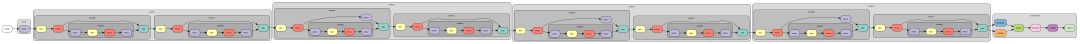

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       8.1052       1.6596       0.3822       0.4761       1.2828       0.5335       8.5813
           2       0.0133       8.1300       1.0103       0.6360       0.4674       1.1504       0.6203      17.1788
           3       0.0200       8.1273       0.7564       0.7336       0.4680       0.7823       0.7364      25.7741
           4       0.0267       8.1260       0.6409       0.7788       0.4682       0.6438       0.7766      34.3683
           5       0.0333       8.1273       0.5649       0.8041       0.4678       0.7562       0.7533      42.9634
           6       0.0400       8.1258       0.5120       0.8233       0.4683       0.5827       0.8032      51.5575
           7       0.0467       8.1239       0.4705       0.8378       0.4687       0.5246       0.8197      60.1501
           8       0.0533       8.1203       0.4447       0.8467

In [21]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=1)

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - final (297s)

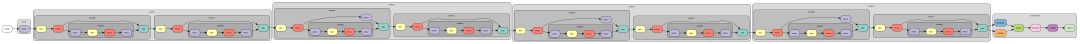

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0067       8.0188       1.6890       0.3726       0.4880       1.2267       0.5499       8.5068
           2       0.0133       8.0108       1.0115       0.6365       0.4879       0.9820       0.6606      17.0054
           3       0.0200       8.0138       0.7641       0.7310       0.4882       0.8996       0.7168      25.5074
           4       0.0267       8.0097       0.6415       0.7770       0.4896       0.6900       0.7646      34.0067
           5       0.0333       8.0139       0.5614       0.8056       0.4883       0.5932       0.8003      42.5089
           6       0.0400       8.0086       0.5133       0.8227       0.4878       0.6435       0.7797      51.0053
           7       0.0467       8.0073       0.4705       0.8374       0.4895       0.5561       0.8133      59.5022
           8       0.0533       8.0195       0.4398       0.8490

In [22]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

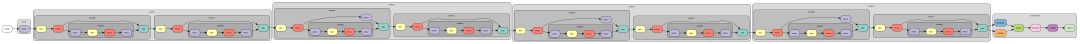

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       6.9102       1.7367       0.3520       0.4364       1.3308       0.5194       7.3466
           2       0.0587       6.9101       1.0568       0.6181       0.4375       1.3619       0.5442      14.6942
           3       0.0880       6.9035       0.7720       0.7290       0.4377       0.9958       0.6513      22.0354
           4       0.1173       6.9061       0.6302       0.7815       0.4418       0.8285       0.7298      29.3833
           5       0.1467       6.8933       0.5548       0.8076       0.4364       0.7106       0.7581      36.7130
           6       0.1760       6.8901       0.4937       0.8303       0.4366       0.5640       0.8067      44.0397
           7       0.2053       6.8906       0.4470       0.8469       0.4374       0.5474       0.8155      51.3676
           8       0.2347       6.9012       0.4207       0.8549

In [18]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

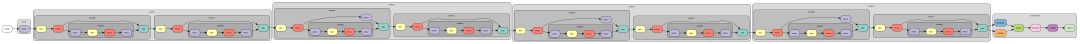

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0293       4.9656       1.7396       0.3542       0.3777       1.3201       0.5249       5.3433
           2       0.0587       4.9870       1.0842       0.6096       0.3787       1.1514       0.6079      10.7089
           3       0.0880       4.9628       0.7880       0.7197       0.3784       0.7102       0.7536      16.0501
           4       0.1173       4.9574       0.6383       0.7773       0.3784       0.9907       0.6792      21.3859
           5       0.1467       4.9560       0.5615       0.8045       0.3786       0.6710       0.7735      26.7205
           6       0.1760       4.9645       0.4945       0.8299       0.3782       0.6469       0.7775      32.0633
           7       0.2053       4.9619       0.4521       0.8438       0.3783       0.6008       0.7945      37.4035
           8       0.2347       4.9694       0.4227       0.8532

In [19]:
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device).half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - final, batch_size=512 (161s)

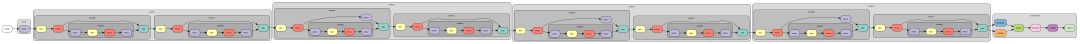

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0500       4.9998       1.7134       0.3621       0.3801       1.3864       0.5118       5.3800
           2       0.1000       4.9976       1.1146       0.5978       0.3817       1.1564       0.6094      10.7592
           3       0.1500       5.0167       0.8621       0.6960       0.3824       0.8509       0.7008      16.1582
           4       0.2000       5.0000       0.7150       0.7513       0.3816       0.9351       0.6791      21.5398
           5       0.2500       4.9926       0.6273       0.7819       0.3829       0.6840       0.7682      26.9152
           6       0.3000       4.9939       0.5680       0.8023       0.3810       0.7726       0.7420      32.2902
           7       0.3500       5.0036       0.5377       0.8132       0.3826       0.6129       0.7911      37.6764
           8       0.4000       4.9892       0.5180       0.8208

In [20]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device).half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - final, batch_size=768 (154s)

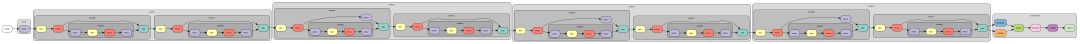

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0750       4.7665       1.8005       0.3312       0.3625       1.7933       0.3988       5.1291
           2       0.1500       4.7631       1.2164       0.5569       0.3616       1.3286       0.5605      10.2538
           3       0.2250       4.7781       0.9234       0.6717       0.3610       1.9069       0.4805      15.3929
           4       0.3000       4.7602       0.7563       0.7353       0.3608       1.2754       0.5916      20.5138
           5       0.3750       4.7607       0.6518       0.7719       0.3608       1.0105       0.6624      25.6353
           6       0.4500       4.7564       0.5858       0.7955       0.3633       0.8114       0.7108      30.7549
           7       0.5250       4.7547       0.5506       0.8092       0.3738       0.6870       0.7603      35.8835
           8       0.6000       4.7589       0.5307       0.8161

In [31]:
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device).half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - new backbone (48s)

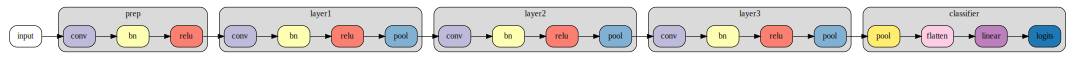

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.1885       1.8071       0.3614       0.2282       1.3434       0.5110       2.4168
           2       0.2000       2.1860       1.1335       0.6016       0.2690       1.0016       0.6363       4.8718
           3       0.3000       2.1862       0.8789       0.6976       0.2288       0.7573       0.7325       7.2867
           4       0.4000       2.1870       0.7529       0.7428       0.2294       0.6579       0.7704       9.7031
           5       0.3750       2.1863       0.6559       0.7785       0.2289       0.5996       0.7956      12.1182
           6       0.3500       2.1851       0.5839       0.8028       0.2291       0.6304       0.7828      14.5325
           7       0.3250       2.2167       0.5385       0.8196       0.2292       0.5816       0.7988      16.9783
           8       0.3000       2.2171       0.5072       0.8323

In [32]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
display(DotGraph(n))
model = TorchGraph(union(n, losses)).to(device).half()
opt = nesterov(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, loggers=(TableLogger(),), 
              num_workers=0)